# Analysis

As always, we start by importing our necessary packages.

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats.distributions import norm

## The Data

Let's import our processed CSV's. There are three to keep track of here:

<font color = 'blue'><b>1) control_norm.csv:</b></font> This dataframe tracks log mRNA proportions for all patients in the CONTROL group. <br>
<font color = 'blue'><b>2) rsv_norm.csv: </b></font> This dataframe tracks log mRNA proportions for all patients in the RSV group. <br>
<font color = 'blue'><b>3) mRNA_signals.csv: </b></font> This dataframe tracks log mRNA proportions for all genes and patients.

Our initial goal here is to <b><font color = 'red'>identify which genes exhibit significant differences in expression between 
control patients and RSV patients</b></font>. To that end, we'll be conducting numerous paired t-tests, using Benjamini-Hochberg to adjust for the multiple-testing fallacy.

In [3]:
# Load in CSVs
control = pd.read_csv('../PROCESSED_DATA/control_norm.csv', header = 0, index_col = 0)
rsv = pd.read_csv('../PROCESSED_DATA/rsv_norm.csv', header = 0, index_col = 0)
mRNA_signals = pd.read_csv('../PROCESSED_DATA/normalized_mRNA_counts.csv', index_col = 0)
pd.set_option('display.max_columns', None) # We'd like to be able to view all columns

genes = control.index # List of all gene candidates

# Obtain mean gene mRNA signal for controls and RSV group
con_mean = control.mean(axis = 1)
rsv_mean = rsv.mean(axis = 1)

# Obtain variance of gene mRNA signal for controls and RSVP group
con_var = control.var(axis = 1)
rsv_var = rsv.var(axis = 1)

# Obtain sample size for controls and RSVP group
con_n = len(control.columns)
rsv_n = len(rsv.columns)

# Compute Z-scores and p-values
Z = (con_mean - rsv_mean) / np.sqrt(con_var / con_n + rsv_var / rsv_n)
p_values = 2 * norm.sf(abs(Z))


########################### TRY BENJAMINI - HOCHBERG ADJUSTMENT ########################### 

b_hoch = multipletests(p_values, alpha = 0.05, method = 'fdr_bh')
rejects = b_hoch[0]
adjusted_p_vals = b_hoch[1]

# Generate a new dataframe with Benjamini - Hochberg statistics for each gene candidate
bhoch_genes = pd.DataFrame({"Gene": genes, "Mean Diff": rsv_mean - con_mean, "Initial p-val": p_values, 
                            "Adjusted p-values": adjusted_p_vals, "Reject?": rejects})


bhoch_genes.to_csv("../PROCESSED_DATA/all_bhoch_genes.csv") # Write to CSV

# Filter out only the significant genes, reformat and save CSV
bhoch_sig_genes = bhoch_genes[bhoch_genes["Reject?"] == True]
bhoch_sig_genes = bhoch_sig_genes.reset_index()
bhoch_sig_genes.set_index("Gene", inplace = True)
bhoch_sig_genes.index.name = None
bhoch_sig_genes.drop(["index", "Reject?"], inplace = True, axis = 1)
bhoch_sig_genes.sort_values("Adjusted p-values", inplace = True, ascending = True)
bhoch_sig_genes.to_csv("../PROCESSED_DATA/sig_bhoch_genes.csv") # Write to CSV

print("The number of significant genes is: ", bhoch_sig_genes.shape[0])
bhoch_sig_genes.head(5)

##################################################################################################


The number of significant genes is:  220


C:\Users\krdon\AppData\Local\Temp\ipykernel_27108\1096823195.py:4: DtypeWarning: Columns (28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  mRNA_signals = pd.read_csv('../PROCESSED_DATA/normalized_mRNA_counts.csv', index_col = 0)


,Mean Diff,Initial p-val,Adjusted p-values
ERCC6L,0.818106,9.242973e-10,0.000010
MTHFD1L,0.822962,5.142999e-08,0.000270
TNFRSF10B,-0.424061,3.067091e-07,0.001073
CDCA7,1.189502,5.363346e-07,0.001407
LAMTOR4,-0.496856,1.311156e-06,0.002293


Excellent! We've identified 220 candidate genes for further analysis. Let us take a moment to discuss our top two candidates: <b>ERCC6L</b> and <b>MTHFD1L</b>. <br>

<b><font color ='blue'> ERCC Excision Repair 6 Like, Spindle Assembly Checkpoint Helicase (ERCC6L)</font></b> 

In [4]:
mRNA_signals = mRNA_signals.fillna("n/a")
mRNA_signals.tail(10)

# Get original mRNA signals for these candidates
candidate_signals = pd.merge(mRNA_signals, bhoch_sig_genes, left_index=True, right_index=True, how='inner')

# Add back in patient data
candidate_signals = pd.concat([candidate_signals, mRNA_signals.tail(3)])

 # Sort with lowest p-vals at top
candidate_signals.sort_values('Adjusted p-values', inplace = True, ascending = True)

candidate_signals.to_csv("../PROCESSED_DATA/candidate_signals.csv") # Write to CSV
candidate_signals.head(5) # Let's take a look!


,GSM4715941,GSM4715944,GSM4715945,GSM4715946,GSM4715949,GSM4715950,GSM4715955,GSM4715958,GSM4715959,GSM4715960,GSM4715967,GSM4715969,GSM4715974,GSM4715976,GSM4715978,GSM4715979,GSM4715981,GSM4715982,GSM4715983,GSM4715984,GSM4715985,GSM4715991,GSM4715992,GSM4715993,GSM4715998,GSM4716000,GSM4716001,GSM4715942,GSM4715943,GSM4715948,GSM4715951,GSM4715952,GSM4715953,GSM4715957,GSM4715961,GSM4715962,GSM4715963,GSM4715964,GSM4715965,GSM4715966,GSM4715968,GSM4715970,GSM4715971,GSM4715973,GSM4715977,GSM4715980,GSM4715986,GSM4715987,GSM4715988,GSM4715989,GSM4715990,GSM4715994,GSM4715995,GSM4715997,GSM4715999,GSM4716004,GSM4715947,GSM4715954,GSM4715956,GSM4715972,GSM4715975,GSM4715996,GSM4716002,GSM4716003,avg_log_mRNA,Mean Diff,Initial p-val,Adjusted p-values
ERCC6L,-17.798597,-18.836808,-17.106978,-16.809564,-17.51621,-17.267645,-16.851394,-17.061605,-16.700118,-16.1521,-16.821975,-16.790984,-17.121318,-17.005281,-16.038337,-17.519811,-16.389093,-17.024515,-16.258372,-17.286873,-17.311988,-16.931974,-16.84048,-17.181123,-16.050668,-16.398337,-17.729349,-16.06776272968877,-17.245499505164187,-16.170989132365605,-16.559384870944605,-16.883810362671827,-16.252182933790234,-16.281301368263264,-15.368853852574924,-16.752583516815893,-15.801502389249976,-14.852626794408451,-16.684391247521038,-15.922586226847264,-16.743861313851756,-16.72928600640174,-16.021555445233314,-16.68348968599205,-16.191078613807438,-16.454159018661915,-16.31507505943197,-16.68921449354307,-16.181988115346336,-16.587322072062292,-16.467928107525818,-16.22065297292357,-16.249973178394452,-15.757473351560181,-16.169811924828128,-16.187644573823114,-17.23921278732309,-16.838466465622147,-15.84491717555273,-16.60475528225582,-16.088297799497536,-17.524131084567312,-16.866854284352748,-16.467835403353575,-16.637031,0.818106,9.242973e-10,0.000010
MTHFD1L,-18.039605,-18.703541,-17.548983,-17.208113,-16.721029,-16.768839,-16.961019,-17.803807,-16.602821,-16.357082,-16.398944,-17.591675,-17.172543,-16.025089,-16.309365,-17.168339,-16.501913,-17.43003,-16.752482,-17.228926,-18.26892,-17.326605,-17.066362,-18.066664,-15.611662,-16.504537,-17.836265,-16.841486873865094,-16.86522742404602,-16.692941835560962,-16.49329568048683,-16.537359948650394,-16.991531179267433,-17.02891420662898,-15.81933102110906,-15.629602016983853,-15.860396078303545,-15.041155763878614,-16.441348316874706,-15.937772630661938,-16.00249725578803,-16.04244389166137,-16.510593525955937,-15.908304769595354,-16.588838121654447,-15.477242631774956,-15.993146964544605,-16.892031376542757,-16.531795242809135,-16.7222516521484,-16.75906304886758,-16.86567059711569,-16.41347191067733,-15.864388555476692,-16.429198553646778,-15.572934729707907,-17.668056086126967,-17.62087503054952,-16.282725982490234,-16.869170918487974,-16.772795973769608,-18.193982482874983,-16.950109788002102,-16.207445718775343,-16.738977,0.822962,5.142999e-08,0.000270
TNFRSF10B,-13.246372,-14.047852,-13.611568,-13.736808,-13.464121,-13.680071,-14.685384,-13.229816,-13.770298,-14.046209,-13.938788,-13.497385,-13.819662,-14.010208,-13.800091,-13.710089,-14.024396,-13.646371,-14.111066,-14.037701,-14.013197,-13.642467,-13.896437,-14.02598,-14.156726,-13.919574,-13.687039,-13.870871,-13.998778,-13.70222,-14.038439,-13.824505,-14.168927,-13.849128,-13.817444,-14.406408,-14.442142,-14.782237,-13.856386,-14.034449,-14.261584,-13.888802,-14.703239,-13.867859,-14.167374,-14.147579,-14.155027,-13.890331,-14.175102,-14.24493,-14.29394,-14.203725,-13.853456,-13.938389,-14.068451,-13.90966,-14.236639,-14.523264,-13.884177,-14.066562,-14.066423,-14.571265,-13.673156,-14.310294,-13.989826,-0.424061,3.067091e-07,0.001073
CDCA7,-17.726448,-18.469076,-16.576464,-17.580082,-17.848785,-18.39889,-17.887018,-18.061605,-17.711345,-17.557615,-16.585907,-18.054018,-17.570303,-16.731358,-15.373276,-17.470901,-15.829893,-18.073095,-16.836139,-16.750005,-18.712526,-16.944357,-16.14165,-18.167947,-15.288637,-15.53491,-17.662235,-16.31994975328557,-17.032954869784085,-16

In [32]:
# Get original mRNA signals for all genes
gene_signals = pd.merge(mRNA_signals, bhoch_genes, left_index=True, right_index=True, how='inner')

# Add back in patient data
gene_signals = pd.concat([gene_signals, mRNA_signals.tail(3)])

# Sort with lowest p-vals at top
gene_signals.sort_values('Adjusted p-values', inplace = True, ascending = True)

display(gene_signals.head(5))

,GSM4715941,GSM4715944,GSM4715945,GSM4715946,GSM4715949,GSM4715950,GSM4715955,GSM4715958,GSM4715959,GSM4715960,GSM4715967,GSM4715969,GSM4715974,GSM4715976,GSM4715978,GSM4715979,GSM4715981,GSM4715982,GSM4715983,GSM4715984,GSM4715985,GSM4715991,GSM4715992,GSM4715993,GSM4715998,GSM4716000,GSM4716001,GSM4715942,GSM4715943,GSM4715948,GSM4715951,GSM4715952,GSM4715953,GSM4715957,GSM4715961,GSM4715962,GSM4715963,GSM4715964,GSM4715965,GSM4715966,GSM4715968,GSM4715970,GSM4715971,GSM4715973,GSM4715977,GSM4715980,GSM4715986,GSM4715987,GSM4715988,GSM4715989,GSM4715990,GSM4715994,GSM4715995,GSM4715997,GSM4715999,GSM4716004,GSM4715947,GSM4715954,GSM4715956,GSM4715972,GSM4715975,GSM4715996,GSM4716002,GSM4716003,avg_log_mRNA,Gene,Mean Diff,Initial p-val,Adjusted p-values,Reject?
ERCC6L,-17.798597,-18.836808,-17.106978,-16.809564,-17.51621,-17.267645,-16.851394,-17.061605,-16.700118,-16.1521,-16.821975,-16.790984,-17.121318,-17.005281,-16.038337,-17.519811,-16.389093,-17.024515,-16.258372,-17.286873,-17.311988,-16.931974,-16.84048,-17.181123,-16.050668,-16.398337,-17.729349,-16.06776272968877,-17.245499505164187,-16.170989132365605,-16.559384870944605,-16.883810362671827,-16.252182933790234,-16.281301368263264,-15.368853852574924,-16.752583516815893,-15.801502389249976,-14.852626794408451,-16.684391247521038,-15.922586226847264,-16.743861313851756,-16.72928600640174,-16.021555445233314,-16.68348968599205,-16.191078613807438,-16.454159018661915,-16.31507505943197,-16.68921449354307,-16.181988115346336,-16.587322072062292,-16.467928107525818,-16.22065297292357,-16.249973178394452,-15.757473351560181,-16.169811924828128,-16.187644573823114,-17.23921278732309,-16.838466465622147,-15.84491717555273,-16.60475528225582,-16.088297799497536,-17.524131084567312,-16.866854284352748,-16.467835403353575,-16.637031,ERCC6L,0.818106,9.242973e-10,0.000010,True
MTHFD1L,-18.039605,-18.703541,-17.548983,-17.208113,-16.721029,-16.768839,-16.961019,-17.803807,-16.602821,-16.357082,-16.398944,-17.591675,-17.172543,-16.025089,-16.309365,-17.168339,-16.501913,-17.43003,-16.752482,-17.228926,-18.26892,-17.326605,-17.066362,-18.066664,-15.611662,-16.504537,-17.836265,-16.841486873865094,-16.86522742404602,-16.692941835560962,-16.49329568048683,-16.537359948650394,-16.991531179267433,-17.02891420662898,-15.81933102110906,-15.629602016983853,-15.860396078303545,-15.041155763878614,-16.441348316874706,-15.937772630661938,-16.00249725578803,-16.04244389166137,-16.510593525955937,-15.908304769595354,-16.588838121654447,-15.477242631774956,-15.993146964544605,-16.892031376542757,-16.531795242809135,-16.7222516521484,-16.75906304886758,-16.86567059711569,-16.41347191067733,-15.864388555476692,-16.429198553646778,-15.572934729707907,-17.668056086126967,-17.62087503054952,-16.282725982490234,-16.869170918487974,-16.772795973769608,-18.193982482874983,-16.950109788002102,-16.207445718775343,-16.738977,MTHFD1L,0.822962,5.142999e-08,0.000270,True
TNFRSF10B,-13.246372,-14.047852,-13.611568,-13.736808,-13.464121,-13.680071,-14.685384,-13.229816,-13.770298,-14.046209,-13.938788,-13.497385,-13.819662,-14.010208,-13.800091,-13.710089,-14.024396,-13.646371,-14.111066,-14.037701,-14.013197,-13.642467,-13.896437,-14.02598,-14.156726,-13.919574,-13.687039,-13.870871,-13.998778,-13.70222,-14.038439,-13.824505,-14.168927,-13.849128,-13.817444,-14.406408,-14.442142,-14.782237,-13.856386,-14.034449,-14.261584,-13.888802,-14.703239,-13.867859,-14.167374,-14.147579,-14.155027,-13.890331,-14.175102,-14.24493,-14.29394,-14.203725,-13.853456,-13.938389,-14.068451,-13.90966,-14.236639,-14.523264,-13.884177,-14.066562,-14.066423,-14.571265,-13.673156,-14.310294,-13.989826,TNFRSF10B,-0.424061,3.067091e-07,0.001073,True
CDCA7,-17.726448,-18.469076,-16.576464,-17.580082,-17.848785,-18.39889,-17.887018,-18.061605,-17.711345,-17.557615,-16.585907,-18.054018,-17.570303,-16.731358,-15.373276,-17.470901,-15.829893,-18.073095,-16.836139,-16.750005,-18.712526,-16.944357,-16.14165,-18.167947,-15.288637,-15.53491,

Now let's generate a volcano plot of this data.

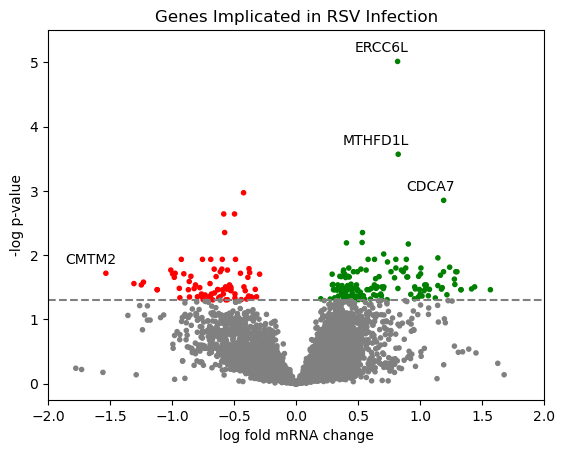

In [69]:
# Generate list of colors for plotting
color_list = []

for i in range(len(gene_signals.index)):
    if not gene_signals.iloc[i]['Reject?']:
        color_list.append('gray')
    elif gene_signals.iloc[i]['Mean Diff'] > 0:
        color_list.append('green')
    else:
        color_list.append('red')

x = gene_signals["Mean Diff"]
y = -np.log10(gene_signals["Adjusted p-values"])

plt.scatter(x, y, c = color_list, marker = '.')

plt.xlabel("log fold mRNA change")
plt.ylabel("-log p-value")
plt.title("Genes Implicated in RSV Infection")
plt.xlim(-2, 2)
plt.ylim(top = 5.5)
plt.axhline(y = -np.log10(0.05), ls = '--', color = 'gray')

labels = ['ERCC6L', 'MTHFD1L', 'CDCA7', 'CMTM2']
for label in labels:
    idx = gene_signals.index.get_loc(label)
    plt.annotate(label, xy = (x[idx], y[idx] + 0.1), xytext = (8, 0), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.savefig("../OUTPUTS/sig_volcano.png")
plt.show()

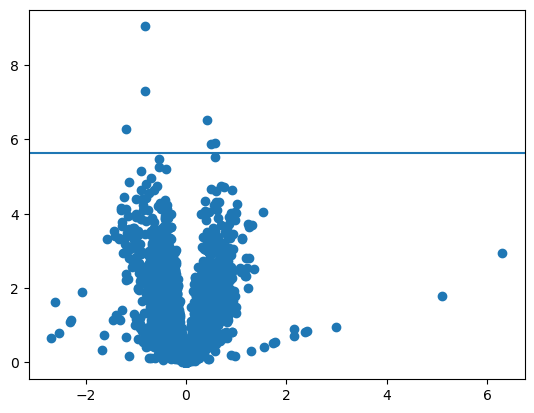

4.574873352131344
TMEM154      4.666702
CYTH4        4.844408
TNFRSF10B    5.119277
LAMTOR4      4.838055
DHX33       -4.644892
CDCA7       -5.012837
ERCC6L      -6.121963
MTHFD1L     -5.446294
dtype: float64
Index(['TMEM154', 'CYTH4', 'TNFRSF10B', 'LAMTOR4', 'DHX33', 'CDCA7', 'ERCC6L',
       'MTHFD1L'],
      dtype='object')


In [92]:
######### BONFERRI CORRECTION + VOLCANO PLOT ###########

log10_p = -np.log10(p_values)
log2_FC = con_mean - rsv_mean

Z_th = -norm.ppf(0.025 / Z.shape[0])
p_th = norm.sf(abs(Z_th))

sig_Z = Z[Z.abs() > Z_th]
sig_p = p_values[p_values < p_th]
sig_genes = sig_Z.index

plt.scatter(log2_FC, log10_p, marker = 'o')
plt.axhline(y = -np.log10(p_th))
plt.show()

print(Z_th)
print(sig_Z)
#print(sig_p)
print(sig_genes)

